# Emotion Detection

**Importing libraries**

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import random
import os
import cv2
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input, Dropout, Flatten,Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation , MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


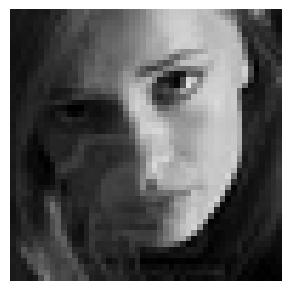

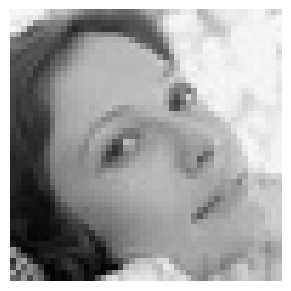

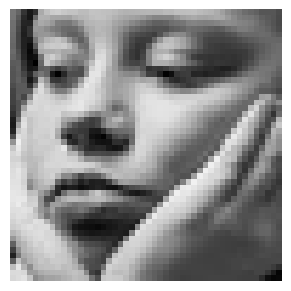

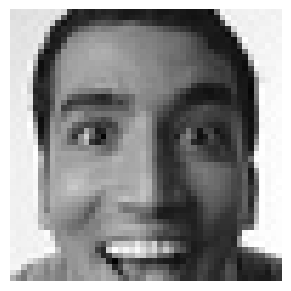

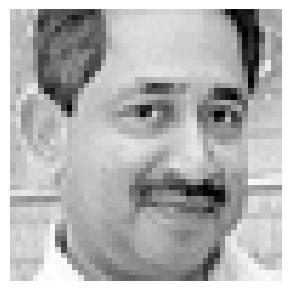

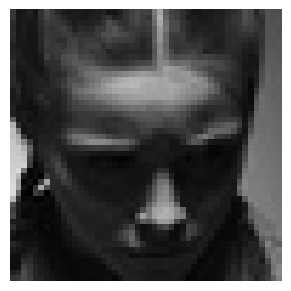

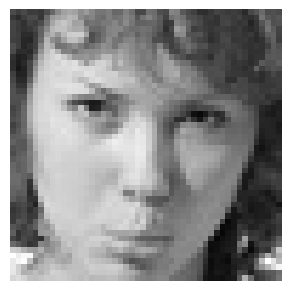

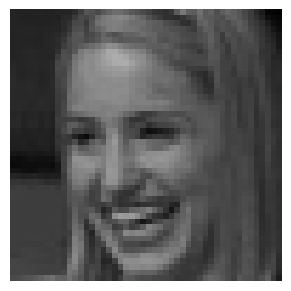

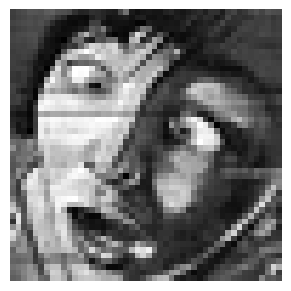

In [2]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing Data For Training**

In [3]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                    target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    shuffle = True)

Found 23028 images belonging to 7 classes.
Found 3656 images belonging to 7 classes.


**Defining Model**

In [4]:
def Convolution(input_tensor,filters,kernel_size):
    x = Conv2D(filters = filters , kernel_size = kernel_size , padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [5]:
def Dense_f(input_tensor,nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [6]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))

    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)
    
    output = Dense(7,activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    
    model.compile(loss = ['categorical_crossentropy'],optimizer = 'adam', metrics = ['accuracy'])
    
    return model
    

In [7]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

**Initialization of Model**

In [8]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint ("model_weights.weights.h5" , monitor = 'val_accuracy' , save_weights_only = True , mode = 'max' , verbose = 1)
callbacks = [checkpoint]

## Training Model

**The next cell takes time to complete**

In [9]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15


C:\Pyton310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.4018 - loss: 1.6249
Epoch 1: saving model to model_weights.weights.h5
719/719 ━━━━━━━━━━━━━━━━━━━━ 610s 840ms/step - accuracy: 0.4018 - loss: 1.6247 - val_accuracy: 0.4693 - val_loss: 1.3268
Epoch 2/15
  1/719 ━━━━━━━━━━━━━━━━━━━━ 7:05 593ms/step - accuracy: 0.5000 - loss: 1.3351

C:\Pyton310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: saving model to model_weights.weights.h5
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5000 - loss: 0.6685 - val_accuracy: 0.3750 - val_loss: 0.8463
Epoch 3/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - accuracy: 0.5511 - loss: 1.1886
Epoch 3: saving model to model_weights.weights.h5
719/719 ━━━━━━━━━━━━━━━━━━━━ 568s 789ms/step - accuracy: 0.5511 - loss: 1.1886 - val_accuracy: 0.3725 - val_loss: 1.5737
Epoch 4/15
  1/719 ━━━━━━━━━━━━━━━━━━━━ 6:47 567ms/step - accuracy: 0.5938 - loss: 1.1775
Epoch 4: saving model to model_weights.weights.h5
719/719 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5938 - loss: 0.5895 - val_accuracy: 0.5000 - val_loss: 0.6207
Epoch 5/15
719/719 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.6176 - loss: 1.0268
Epoch 5: saving model to model_weights.weights.h5
719/719 ━━━━━━━━━━━━━━━━━━━━ 563s 781ms/step - accuracy: 0.6176 - loss: 1.0268 - val_accuracy: 0.5115 - val_loss: 1.2452
Epoch 6/15
  1/719 ━━━━━━━━━━━━━━━━━━━━ 6:52 575ms/step 

**Model Evaluation**

In [10]:
model.evaluate(validation_generator)

115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.5602 - loss: 1.3076


[1.302809715270996, 0.5585339069366455]

**Plotting Loss**

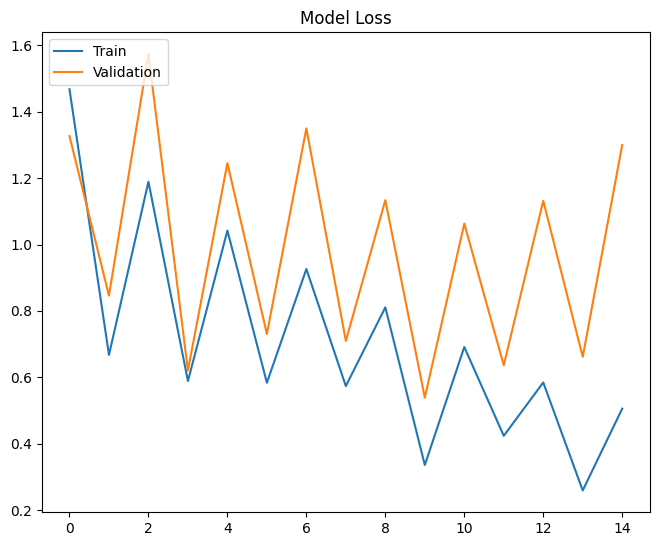

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

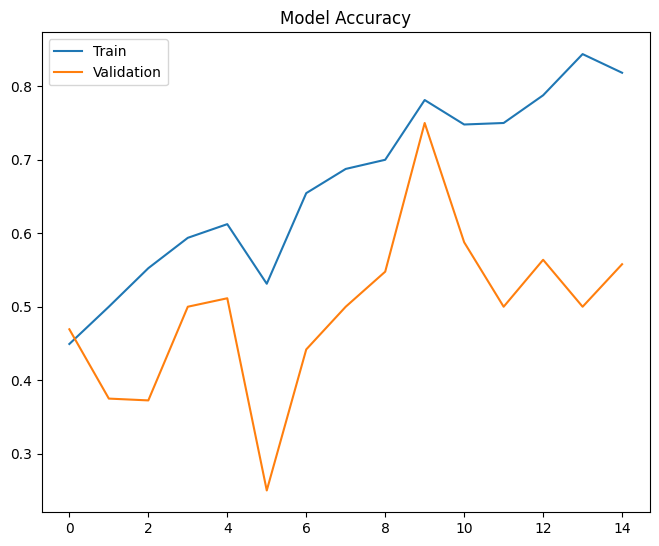

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

**Saving Model**

In [17]:
model_json = model.to_json()
with open("model_a.json","w") as json_file :
    json_file.write(model_json)